In [17]:
import sys
import os

sys.path.append('/Users/raphaelravinet/Code')
import plotly.graph_objects as go
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import logging
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import ta
from algo_trading.Data.log_config import setup_logging
from Fin_Database.Data.connect import engine, DailyStockData, HourlyStockData, OneMinuteStockData, FiveMinuteStockData,FifteenMinuteStockData, StockSplits, StockNews, CompanyFinancials
# from algo_trading.Data.Pre_Processing.pre_processing import PreProcessing
from pykalman import KalmanFilter
from itertools import product

from sklearn.metrics import roc_auc_score, roc_curve, auc

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc, log_loss, confusion_matrix, ConfusionMatrixDisplay

In [2]:
data = pd.read_csv('/Users/raphaelravinet/Code/algo_trading/aapl_daily_final.csv', index_col = 0)
data

,id,date.1,timestamp,ticker,open,high,low,close,volume,vwap,...,sma_slope_30,ema_slope_30,sma_slope_50,ema_slope_50,sma_slope_100,ema_slope_100,sma_slope_200,ema_slope_200,sma_slope_300,ema_slope_300
date,,,,,,,,,,,,,,,,,,,,,
2020-01-06,4605,2020-01-06,1578286800000,AAPL,73.4475,74.9900,73.1875,74.9500,118518576.0,74.4499,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-07,4606,2020-01-07,1578373200000,AAPL,74.9600,75.2250,74.3700,74.5975,111510620.0,74.7311,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-08,4607,2020-01-08,1578459600000,AAPL,74.2900,76.1100,74.2890,75.7975,132363784.0,75.2914,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-09,4608,2020-01-09,1578546000000,AAPL,76.8088,77.6075,76.5500,77.4075,170486168.0,77.1610,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-10,4609,2020-01-10,1578632400000,AAPL,77.6500,78.1675,77.0625,77.5825,140869088.0,77.6729,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-26,5751,2024-07-26,1721966400000,AAPL,218.7000,219.4900,216.0100,217.9600,39827645.0,217.8992,...,0.264850,0.036604,0.330544,0.167794,0.210758,0.198719,0.114984,0.151804,0.084057,0.124633
2024-07-29,5752,2024-07-29,1722225600000,AAPL,216.9600,219.3000,215.7500,218.2400,35153729.0,218.1319,...,0.159067,-0.007568,0.301534,0.134429,0.217707,0.180246,0.107467,0.142635,0.081918,0.118545
2024-07-30,5753,2024-07-30,1722312000000,AAPL,219.1900,220.3250,216.1200,218.8000,40681625.0,218.4059,...,0.090907,-0.003326,0.285397,0.131324,0.235160,0.177600,0.104841,0.141670,0.081078,0.118070


In [3]:
import plotly.graph_objects as go


In [4]:
data = data.iloc[303:].copy()

In [5]:
data.index = pd.to_datetime(data.index)

In [6]:
fig = go.Figure(data = go.Candlestick(x = data.index,
                                      open = data['open'],
                                      high = data['high'],
                                      low = data['low'],
                                      close = data['close'],
                                      increasing=dict(line=dict(color='black')),
                                      decreasing=dict(line=dict(color='red')),
                                      showlegend=False))

layout = go.Layout(
    title=' Apple Stock Price - 2020 to 2024',
    yaxis=dict(title='Price (USD)'),
    xaxis=dict(title='Date'),
    template = 'ggplot2',
    xaxis_rangeslider_visible=False,
    yaxis_gridcolor='white',
    xaxis_gridcolor='white',
    yaxis_tickfont=dict(color='black'),
    xaxis_tickfont=dict(color='black'),
    margin=dict(t=50,l=50,r=50,b=50)
)

fig.update_layout(layout)


fig.show()

In [7]:
data['target'] = np.where(data['log_ret'].shift(-1) > 0, 1, 0)


In [8]:
train = data.iloc[:int(0.8*len(data))]
test = data.iloc[int(0.8*len(data)):]
X_train = train.drop(columns = ['target', 'ticker','date.1'])
y_train = train['target']
X_test = test.drop(columns = ['target', 'ticker','date.1'])
y_test = test['target']

In [12]:
models = [
    ("XGBoost", XGBClassifier()),
    ("CatBoost", CatBoostClassifier(verbose=False)),
    ("RandomForest", RandomForestClassifier())
]

XGBoost ROC AUC: 0.4555555555555556
XGBoost Log Loss: 1.4397446767459485


<Figure size 1000x1000 with 0 Axes>

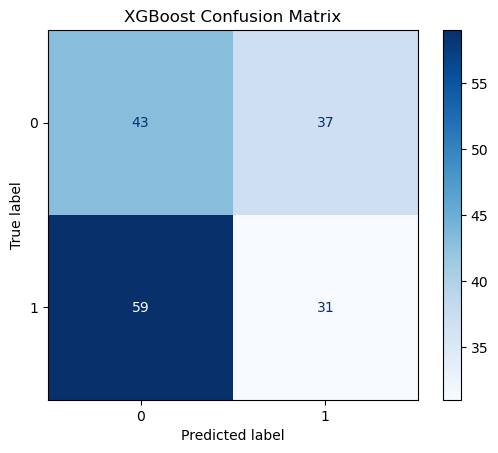

CatBoost ROC AUC: 0.47013888888888894
CatBoost Log Loss: 0.8066115365974679


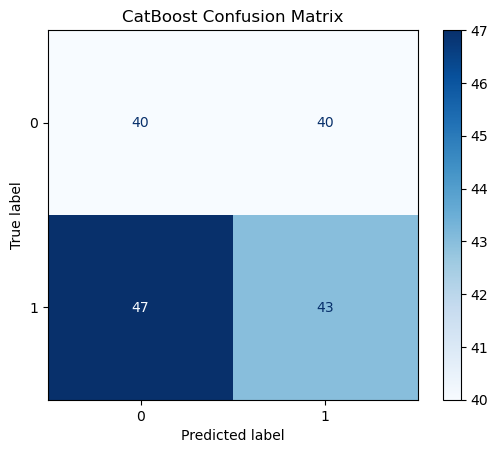

RandomForest ROC AUC: 0.5015277777777778
RandomForest Log Loss: 0.7297951348221758


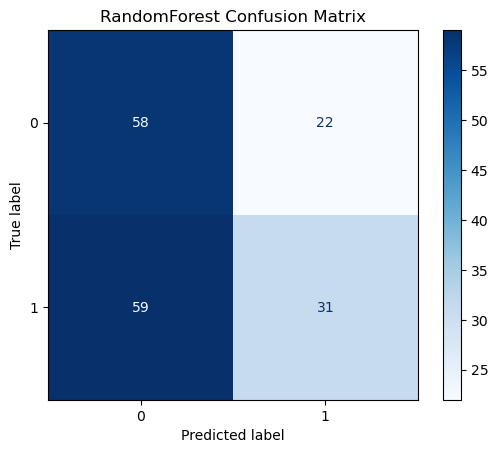

In [20]:
plt.figure(figsize=(10, 10))
for name, model in models:
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_test)[:, 1] 
    y_pred = model.predict(X_test) 
    
    # Metrics
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    log_loss_value = log_loss(y_test, y_pred_proba)

    print(f'{name} ROC AUC: {roc_auc}')
    print(f'{name} Log Loss: {log_loss_value}')
    
    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    
    #CM
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'{name} Confusion Matrix')
    plt.show()

In [ ]:
kf = KalmanFilter(transition_matrices=[1],
                  observation_matrices=[1],
                  initial_state_mean=0,
                  initial_state_covariance=1,
                  observation_covariance=1,
                  transition_covariance=0.01)

In [ ]:
close_prices = data['close']

In [ ]:
state_means, state_cov = kf.filter(close_prices.values)
kalman_avg = state_means.flatten()